In [1]:
from __future__ import print_function, division
import time, os
import numpy as np
import matplotlib.pyplot as plt
import sys
#import networkx as nx
import pandas
import math

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# load cleaned data
#selected_snapshots.read_csv('/home/cs231n/data/snapshots_cleaned.csv')
#selected_repairs.read_csv('/home/cs231n/data/repairs_cleaned.csv')
selected_snapshots = pandas.read_pickle('cleaned_selected_snapshots.pkl')
selected_repairs = pandas.read_pickle('cleaned_selected_repairs.pkl')

# Reset indices of loaded dataframes
selected_snapshots = selected_snapshots.reset_index(drop=True)
selected_repairs = selected_repairs.reset_index(drop=True)

In [4]:
def get_012_dates(end_date):
    ## split into 0 (10+), 1 (5-10), 2(0-5)
    two_end = end_date
    one_end = pandas.to_datetime(two_end) + pandas.DateOffset(days=-5)
    zero_end = one_end + pandas.DateOffset(days=-5)
    return (zero_end, one_end, two_end)

In [5]:
#-------------------------------------------------------------
# Label Snapshots: creates a new column 'state' in selected_snapshots and populates the state
# 0: 10 or more days before repair date
# 1: 5 - 9 days
# 2: < 5 days before repair date
#-------------------------------------------------------------
# Create a new column 'state' for the label of each snapshot
selected_snapshots['state'] = 0

# List to count #snapshots before each repair date
snapshot_size = []

repairs = selected_repairs[selected_repairs['Repair Cost'].isin(['very high', 'high ', 'medium'])]

# Label state of each snapshot as 0, 1 or 2
for veh_id in repairs['Chassis\nReference\nNumber']:
    v_snapshots = selected_snapshots[selected_snapshots['Veh Ref ID'] == veh_id].sort_values(by='Event DateTime')
    v_repairs = repairs[repairs['Chassis\nReference\nNumber'] == veh_id].sort_values(by='Rpr_Dt')
    
    start = pandas.to_datetime('1/1/2000') ## in past so first snapshot is captured
    event_dt_key = 'Event DateTime'
    state_key = 'state'
    
    for repairDate in v_repairs['Rpr_Dt']: # v_repairs has been sorted by 'Rpr_Dt'       
        mask = (v_snapshots[event_dt_key] > start) & (v_snapshots[event_dt_key] <= repairDate)
        snapshot_size.append({'Chassis\nReference\nNumber':veh_id, 'Rpr_Dt':repairDate, 'Snapshot Qty before Rpr_Dt':sum(mask)})
        
        # divide up snapshots into 0, 1, 2 slices and initialize corresponding state for each snapshot as 0, 1, 2 respectively
        (zero_end, one_end, two_end) = get_012_dates(repairDate)
        two_index = v_snapshots.index[(v_snapshots[event_dt_key] > one_end) & (v_snapshots[event_dt_key] <= two_end)]
        one_index = v_snapshots.index[(v_snapshots[event_dt_key] > zero_end) & (v_snapshots[event_dt_key] <= one_end)]
        zero_index = v_snapshots.index[(v_snapshots[event_dt_key] >= start) & (v_snapshots[event_dt_key] <= zero_end)]
        selected_snapshots.loc[two_index,state_key] = 2
        selected_snapshots.loc[one_index,state_key] = 1
        selected_snapshots.loc[zero_index,state_key] = 0
        
        ## reset start to repairDate to initialize states until next repairDate
        start = repairDate
    
    # initialize states beyond last repair date to 'np.nan'
    other_index = v_snapshots.index[v_snapshots[event_dt_key] > repairDate]
    selected_snapshots.loc[other_index,state_key] = np.nan

# Tabulate #snapshots before repair date for the selected repairs (i.e. medium/high/very high cost)
pandas.DataFrame(snapshot_size)

,Chassis Reference Number,Rpr_Dt,Snapshot Qty before Rpr_Dt
0,208.0,2016-02-18,80
1,761.0,2016-03-08,109
2,765.0,2016-03-07,209
3,60.0,2016-03-31,969
4,182.0,2016-04-26,288
5,543.0,2016-03-29,218
6,319.0,2016-04-13,4
7,27.0,2016-04-08,8
8,460.0,2016-03-04,35
9,18.0,2016-04-25,238


In [16]:
# Count #instance for each state
frequency = []
for s in [0,1,2]:
    frequency.append({s:sum(selected_snapshots['state'] == s)})
frequency.append({'NaN':selected_snapshots['state'].isnull().sum()})

frequency

[{0: 917601}, {1: 4683}, {2: 4698}, {'NaN': 88089}]

In [6]:
#------------------------------------------------------------
# Data Cleaning - Part 2 
#------------------------------------------------------------
# Datatype Assignement - selected_snapshot
# Assign correct datatype for categorical variables in selected_snapshots     
category_var = ['Veh Ref ID','Event Type Description','Brake Switch','Clutch Switch','Cruise Status','Dpf Regen Inhibit Sw', 
                'Dpf Thermal Mngmnt','Eng Coolant Level','Population','DTCID','state']

for i in category_var:
    selected_snapshots[i] = selected_snapshots[i].astype('category')
    
header = list(selected_snapshots.columns.values)
print('Feature:\tDatatype\t#Unique Entries')
for i in header:
    print('%s:\t%s\t%s' % (i, selected_snapshots[i].dtype, len(selected_snapshots[i].unique())))

# Drop dominant column 'Polulation': only 1 unique value ('2') for all snapshots
selected_snapshots.drop('Population', axis=1, inplace=True)

Feature:	Datatype	#Unique Entries
Veh Ref ID:	category	797
Event DateTime:	datetime64[ns]	956362
Event Type Description:	category	4
Acc Pedal Position:	float64	251
Ambient Air Temp:	float64	696
Barometric Press:	float64	76
Brake Switch:	category	2
Bus Utilization:	float64	83
Cat Intake Gas Temp:	float64	4462
Cat Outlet Gas Temp:	float64	5152
Clutch Switch:	category	2
Cmd Eng Fuel Press:	float64	20405
Cruise Status:	category	2
Dpf Regen Inhibit Sw:	category	3
Dpf Thermal Mngmnt:	category	2
Drvr Demand Torque:	float64	102
Eng Air Flow Rate:	float64	18800
Eng Avg Fuel Econ:	float64	4129
Eng Coolant Level:	category	3
Eng Coolant Temp:	float64	129
Eng Demand Torque:	float64	104
Eng DPF Intake Press:	float64	63
Eng Egr Valve Pos:	float64	1001
Eng Exhaust Gas Temp:	float64	601
Eng Fuel Del Press:	float64	255
EngFuelTemp1:	float64	102
Engine Speed:	float64	6353
Eng Man Abs Pressure:	float64	159
Eng Oil Pressure:	float64	196
EngInjRail1Press:	float64	2472
EngIntakeMan1Temp:	float64	126
EngOilTe

In [7]:
# Explore how some categorical variables affect the distribution of state
selected_category_var = ['Event Type Description','Brake Switch','Clutch Switch','Cruise Status','Dpf Regen Inhibit Sw', 
                         'Dpf Thermal Mngmnt','Eng Coolant Level']
for j in selected_category_var:
    print(j)
    for key, group in selected_snapshots.groupby(j):
        print ('%s: %s' % (j, key))
        for i in [0,1,2]:
            print('%s: %s' % (i, sum(group['state']==i)/len(group)))
        print('NaN: %s' % (sum(group['state'].isnull())/len(group)))
    print('\n')

# State distribution was found to change very little for different categories of the following variables
# Suggest to remove these columns?
insensitive_variables = ['Brake Switch', 'Dpf Thermal Mngmnt']

# Event Type Description: state distribution is similar for 'trip_end', 'trip_periodic', 'trip_start'. 
# Suggest to group 'trip_end', 'trip_periodic', 'trip_start' into one category: 'trip'?

Event Type Description
Event Type Description: fault
0: 0.916873361208
1: 0.00283466798951
2: 0.00425200198427
NaN: 0.0760399688187
Event Type Description: trip_end
0: 0.904591157416
1: 0.00466810775602
2: 0.00460424855279
NaN: 0.0861364862751
Event Type Description: trip_periodic
0: 0.901951583662
1: 0.00454036472219
2: 0.00473498986883
NaN: 0.0887730617468
Event Type Description: trip_start
0: 0.905209935687
1: 0.00472671103422
2: 0.00454122440364
NaN: 0.0855221288748


Brake Switch
Brake Switch: 0.0
0: 0.904418963783
1: 0.00461611378626
2: 0.00467285560431
NaN: 0.0862920668263
Brake Switch: 1.0
0: 0.900561657621
1: 0.0045930347574
2: 0.00428339196477
NaN: 0.0905619156567


Clutch Switch
Clutch Switch: 0.0
0: 0.904914137291
1: 0.00445438885763
2: 0.00457255103468
NaN: 0.0860589228162
Clutch Switch: 1.0
0: 0.894644206889
1: 0.00619803476946
2: 0.00518302559119
NaN: 0.0939747327502


Cruise Status
Cruise Status: 0.0
0: 0.903727279171
1: 0.00456753760822
2: 0.00459219368168
NaN: 0.08711

In [8]:
def split_test_train(repairs):
    mask = (repairs['Chassis\nReference\nNumber']==0) #all false
    
    for repairCode in repairs['ATA9'].unique():    
        v_repairs = repairs[repairs['ATA9'] == repairCode]
        idx = v_repairs.index
        print(repairCode, len(v_repairs))

        if len(v_repairs) > 1:
            # randomly select N cases with matching ATA9 code
            # where N = maxTestCase ~ 20% of #cases with the same ATA9 code
            maxTestCase = math.ceil(0.2*len(v_repairs))
            a = list(range(0,maxTestCase))
            np.random.shuffle(a)
            mask.loc[idx[a[0:maxTestCase]]] = True

    #mask.loc[idx[a[0:maxTestCase]]]
    test = repairs[mask][['Chassis\nReference\nNumber','ATA9','Rpr_Dt','Repair Cost']].sort_values('ATA9')
    train = repairs[~mask][['Chassis\nReference\nNumber','ATA9','Rpr_Dt', 'Repair Cost']].sort_values('ATA9')
    
    #print([test, train])
    return [test, train]

In [9]:
very_high_repairs = selected_repairs[selected_repairs['Repair Cost'].isin(['very high'])]
[veryhigh_test, veryhigh_train] = split_test_train(very_high_repairs)
[veryhigh_test, veryhigh_train]

45002000 4
45007001 2
45002072 3
43006007 1


[     Chassis\nReference\nNumber      ATA9     Rpr_Dt Repair Cost
 99                         27.0  45002000 2016-04-08   very high
 315                       555.0  45002072 2016-05-17   very high
 132                        25.0  45007001 2016-04-22   very high,
      Chassis\nReference\nNumber      ATA9     Rpr_Dt Repair Cost
 600                       340.0  43006007 2016-06-30   very high
 295                       724.0  45002000 2016-06-10   very high
 414                       495.0  45002000 2016-06-14   very high
 547                       751.0  45002000 2016-06-10   very high
 426                       180.0  45002072 2016-05-31   very high
 576                       801.0  45002072 2016-07-05   very high
 594                       373.0  45007001 2016-07-04   very high]

In [10]:
high_repairs = selected_repairs[selected_repairs['Repair Cost'].isin(['high '])]
[high_test, high_train] = split_test_train(high_repairs)
[high_test, high_train]

45007001 3
45002072 2
44003016 1
43004000 2
45008098 2
44004001 1


[     Chassis\nReference\nNumber      ATA9     Rpr_Dt Repair Cost
 228                       251.0  43004000 2016-05-18       high 
 127                       470.0  45002072 2016-04-22       high 
 120                       767.0  45007001 2016-04-24       high 
 262                       504.0  45008098 2016-06-10       high ,
      Chassis\nReference\nNumber      ATA9     Rpr_Dt Repair Cost
 397                       102.0  43004000 2016-06-30       high 
 160                       231.0  44003016 2016-04-15       high 
 407                       180.0  44004001 2016-07-07       high 
 528                       750.0  45002072 2016-06-03       high 
 318                       768.0  45007001 2016-05-11       high 
 455                       674.0  45007001 2016-07-21       high 
 710                       222.0  45008098 2016-06-30       high ]

In [11]:
medium_repairs = selected_repairs[selected_repairs['Repair Cost'].isin(['medium'])]
[medium_test, medium_train] = split_test_train(medium_repairs)
[medium_test, medium_train]

44003217 1
43001071 1
45021003 12
44004001 41
45007031 1
45018000 2
43001058 2
45007001 1
44003027 2
45013001 1
43001049 2
45002072 1
13009001 1
101001001 1
43007023 1
44014014 2
3001082 1
43006007 1
45007007 1
45002000 1
43007096 1


[     Chassis\nReference\nNumber      ATA9     Rpr_Dt Repair Cost
 296                       571.0  43001049 2016-06-01      medium
 215                       165.0  43001058 2016-04-04      medium
 260                       597.0  44003027 2016-05-31      medium
 59                        182.0  44004001 2016-04-26      medium
 72                        543.0  44004001 2016-03-29      medium
 76                        319.0  44004001 2016-04-13      medium
 104                       460.0  44004001 2016-03-04      medium
 105                        18.0  44004001 2016-04-25      medium
 128                       270.0  44004001 2016-04-14      medium
 156                       233.0  44004001 2016-03-22      medium
 159                       558.0  44004001 2016-03-23      medium
 161                       605.0  44004001 2016-04-19      medium
 543                       722.0  44014014 2016-06-28      medium
 139                       245.0  45018000 2016-04-12      medium
 53       

In [12]:
test = veryhigh_test
train = veryhigh_train
test = test.append(high_test)
test = test.append(medium_test)
train = train.append(high_train)
train = train.append(medium_train)
[len(test), len(train)]

[24, 74]

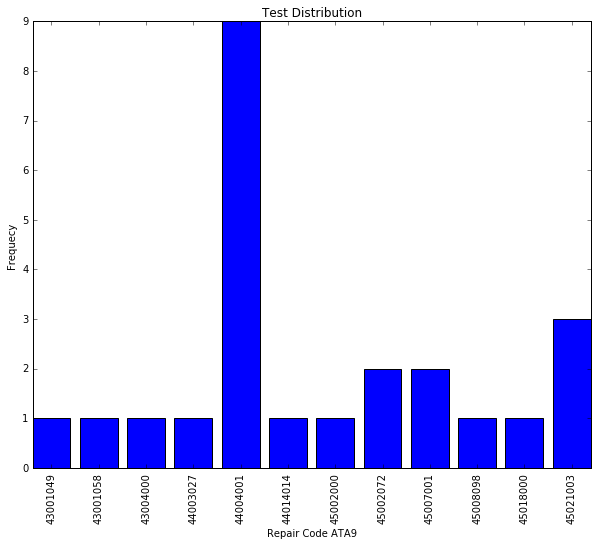

In [13]:
# Plot Test Distribution
bars = []
heights = []
for repair_type, repair_group in test.groupby('ATA9'):
    bars.append(repair_type)
    heights.append(len(repair_group))
numbars = len(bars)
# range(numbars) in following command yields [0,1,...,numbars-1]
plt.xticks(range(numbars), bars, rotation='vertical')
plt.bar(range(numbars), heights, align='center')
plt.xlabel('Repair Code ATA9')
plt.ylabel('Frequecy')
plt.title('Test Distribution')
plt.show()

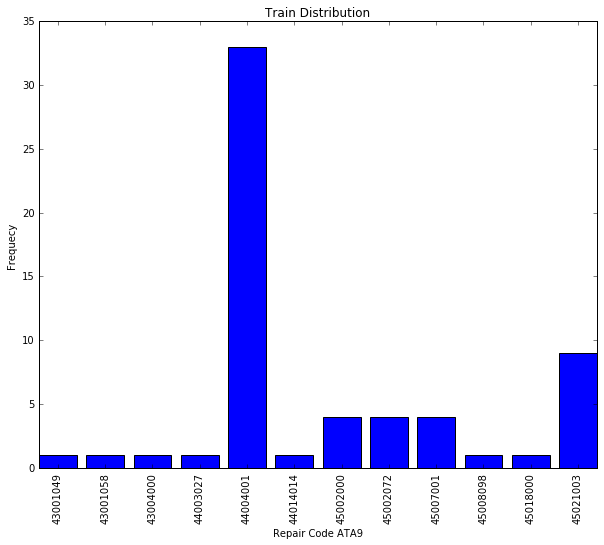

In [14]:
# Plot Training Distribution
bars1 = [] 
heights1 = [] 
for repair_type, repair_group in train.groupby('ATA9'):
    if(repair_type in set(test['ATA9'])):
        bars1.append(repair_type)
        heights1.append(len(repair_group))
numbars1 = len(bars1)
# range(numbars) in following command yields [0,1,...,numbars-1]
plt.xticks(range(numbars1), bars1, rotation='vertical')
plt.bar(range(numbars1), heights1, align='center')
plt.xlabel('Repair Code ATA9')
plt.ylabel('Frequecy')
plt.title('Train Distribution')
plt.show()

In [15]:
#-------------------------------------------------------------
# Define: ok = no repairs with medium, high or very high cost
# Split "ok" vehicles into ok_test, ok_train for inclusion in test and train (if necessary)
#-------------------------------------------------------------
# Get "ok" vehicle IDs
ok_veh_ids = list(set(selected_snapshots['Veh Ref ID'].unique()) - set(high_repairs['Chassis\nReference\nNumber'].unique()))
ok_veh_ids = (np.array(ok_veh_ids))

# Get random permutation of indices of ok_veh_ids
a = pandas.Series(np.random.random(len(ok_veh_ids)))
a = a.sort_values().index

# split ok vehicles into test and train with the same proportion as those with medium, high & very high repair Cost 
test_train_proportion = len(test)/(len(test)+len(train))
maxTestCase = round(len(ok_veh_ids)*test_train_proportion)
ok_test = ok_veh_ids[a[0:maxTestCase].values]
ok_train = ok_veh_ids[a[maxTestCase:]]

[len(ok_test),len(ok_train)]

[192, 594]

In [17]:
#------------------------------------------------------------
# Split snapshots into test_snapshots and train_snapshots (snapshots of 'ok' vehicles excluded for now)
#------------------------------------------------------------
test_snapshots = selected_snapshots[selected_snapshots['Veh Ref ID'].isin(test['Chassis\nReference\nNumber'].unique())]
train_snapshots = selected_snapshots[selected_snapshots['Veh Ref ID'].isin(train['Chassis\nReference\nNumber'].unique())]
[test_snapshots.shape, train_snapshots.shape]

[(38643, 64), (100764, 64)]

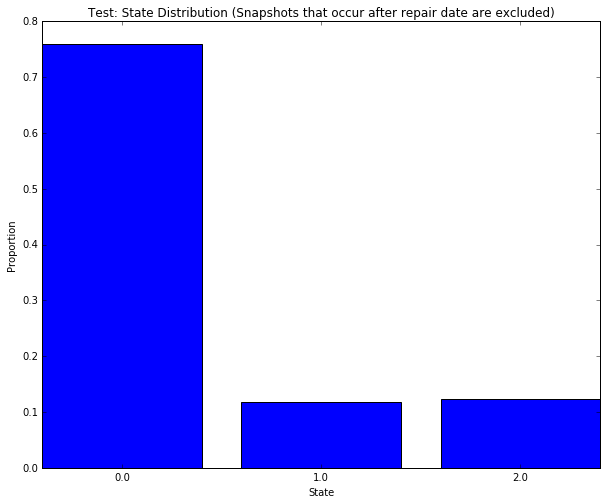

In [18]:
# Plot test snapshot distribution ('NaN' snapshots that occur after repair date are not shown)
bars2 = [] 
heights2 = []
total2 = sum(~test_snapshots['state'].isnull())
for state, state_group in test_snapshots.groupby('state'):
    bars2.append(state)
    heights2.append(len(state_group)/total2)
#bars2.append('NaN')
#heights2.append(train_snapshots['state'].isnull().sum()/total2)
numbars2 = len(bars2)
# range(numbars) in following command yields [0,1,...,numbars-1]
plt.xticks(range(numbars2), bars2)
plt.bar(range(numbars2), heights2, align='center')
plt.xlabel('State')
plt.ylabel('Proportion')
plt.title('Test: State Distribution (Snapshots that occur after repair date are excluded)')
plt.show()

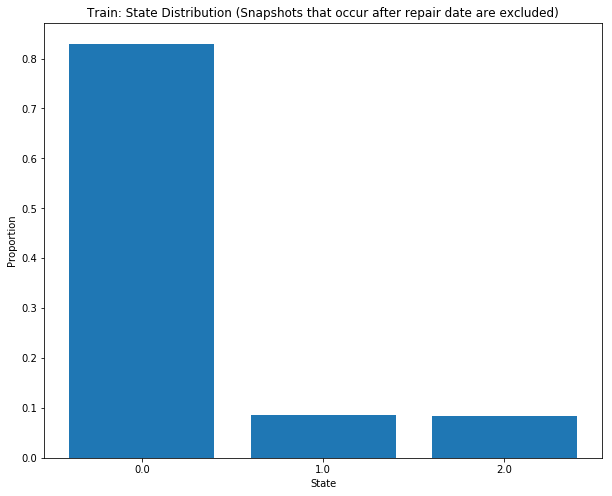

In [36]:
# Plot training snapshot distribution
bars3 = [] 
heights3 = [] 
total3 = sum(~train_snapshots['state'].isnull())
for state, state_group in train_snapshots.groupby('state'):
    bars3.append(state)
    heights3.append(len(state_group)/total3)
#bars3.append('NaN')
#heights3.append(train_snapshots['state'].isnull().sum()/total3)
numbars3 = len(bars3)
# range(numbars) in following command yields [0,1,...,numbars-1]
plt.xticks(range(numbars3), bars3)
plt.bar(range(numbars3), heights3, align='center')
plt.xlabel('State')
plt.ylabel('Proportion')
plt.title('Train: State Distribution (Snapshots that occur after repair date are excluded)')
plt.show()

In [19]:
# Save output to csv
test_snapshots.to_csv('test_snapshots.csv')
train_snapshots.to_csv('train_snapshots.csv')
test.to_csv('test.csv')
train.to_csv('train.csv')

In [25]:
train_snapshots.info

<bound method DataFrame.info of         Veh Ref ID      Event DateTime Event Type Description  \
574          768.0 2016-03-15 21:05:48               trip_end   
575          768.0 2016-03-17 13:06:16             trip_start   
576          768.0 2016-03-16 19:27:42               trip_end   
577          768.0 2016-03-17 17:10:36               trip_end   
578          768.0 2016-03-16 17:36:17             trip_start   
579          768.0 2016-03-16 19:27:20             trip_start   
580          768.0 2016-03-08 20:16:06               trip_end   
581          768.0 2016-03-08 20:13:44             trip_start   
582          768.0 2016-03-24 20:48:59               trip_end   
583          768.0 2016-03-24 20:47:41             trip_start   
584          768.0 2016-03-24 20:58:13             trip_start   
585          768.0 2016-03-30 19:03:04               trip_end   
586          768.0 2016-03-24 20:58:48               trip_end   
587          768.0 2016-03-30 19:02:11             trip_st